# Generate simulated data

In this notebook we generate a simulated dataset based on experimental data. 
- The maps are directly extracted from the experimental data.
- The phases (or spectra) are built using chemical composition extracted from the literature (citations to be included)

The output of this notebook is put in the `generated_datasets` 


## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# espm imports
from espm.datasets.base import generate_dataset
from espm.weights.generate_weights import chemical_map_weights
from espm.models.generate_EDXS_phases import generate_modular_phases
from espm.models.EDXS_function import elts_list_from_dict_list

# Generic imports 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs



## Generate weights

We use an experimental dataset to create realistic abundance maps. Theses maps are based from chemical mapping of the dataset.

In [2]:
def get_repo_path():
    """Get the path to the git repository.
    
    This is a bit of a hack, but it works.
    """
    this_path = Path.cwd() / Path("generate_data.ipynb")
    return this_path.resolve().parent.parent

# Path of the experimental dataset
path = get_repo_path() / Path("experiments/71GPa_experimental_data.hspy")

# Creation of the weights
weights = chemical_map_weights( file = path, line_list = ["Fe_Ka","Ca_Ka"], conc_list = [0.5,0.5])

/home/adrien/.local/lib/python3.8/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/adrien/.local/lib/python3.8/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '
/home/adrien/.local/lib/python3.8/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/adrien/.local/lib/python3.8/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Sett

#### Plot the results

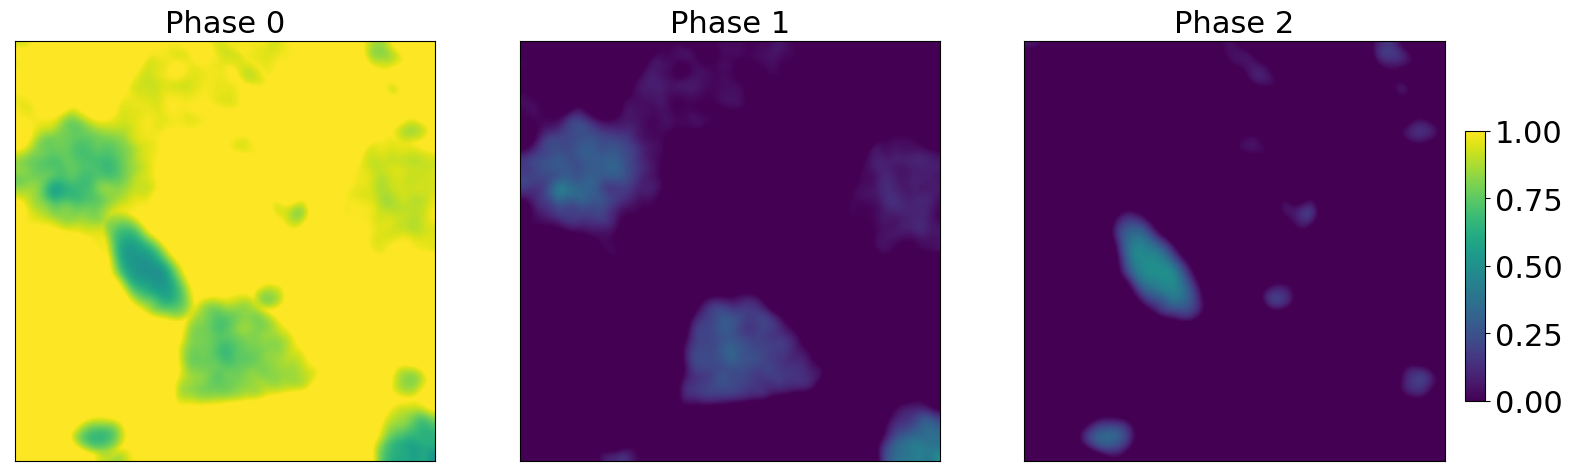

In [3]:
fig,axs = plt.subplots(1,3,figsize = (20,20*3))
for j in range(axs.shape[0]) :
    im = axs[j].imshow(weights[:,:,j],vmin = 0, vmax = 1.0)
    axs[j].tick_params(axis = "both",width = 0,labelbottom = False,labelleft = False) 
    axs[j].set_title("Phase {}".format(j),fontsize = 22)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.47, 0.01, 0.045])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.tick_params(labelsize=22)

## Generate phases

We generate phases based on values extracted from the literature. The phases we try to simulate here are Ferropericlase, Bridgmanite and Ca-perovskite.


### Model parameters

We use dictionnaries to input the modelling parameters.

In [4]:
# Elemental concetration of each phase
elts_dicts = [
    # Pseudo ferropericlase
    {
        "Mg" : 0.522, "Fe" : 0.104, "O" : 0.374, "Cu" : 0.05
    },
    # Pseudo Ca-Perovskite
    {
        "Mg" : 0.020, "Fe" : 0.018, "Ca" : 0.188, "Si" : 0.173, "Al" : 0.010, "O" : 0.572, "Ti" : 0.004, "Cu" : 0.05, "Sm" : 0.007, "Lu" : 0.006, "Nd" : 0.006 
    },
    # Pseudo Bridgmanite
    {
        "Mg" : 0.445, "Fe" : 0.035, "Ca" : 0.031, "Si" : 0.419, "Al" : 0.074, "O" : 1.136, "Cu" : 0.05, "Hf" : 0.01
    }]

# Parameters of the bremsstrahlung
brstlg_pars = [
    {"b0" : 0.0001629, "b1" : 0.0009812},
    {"b0" : 0.0007853, "b1" : 0.0003658},
    {"b0" : 0.0003458, "b1" : 0.0006268}
]

# Model parameters : energy scale, detector broadening, x-ray emission database, beam energy, absorption parameters, detector efficiency
model_params = {
        "e_offset" : 0.3,
        "e_size" : 1980,
        "e_scale" : 0.01,
        "width_slope" : 0.01,
        "width_intercept" : 0.065,
        "db_name" : "default_xrays.json",
        "E0" : 200,
        "params_dict" : {
            "Abs" : {
                "thickness" : 100.0e-7,
                "toa" : 35,
                "density" : 4.5,
                "atomic_fraction" : False
            },
            "Det" : "SDD_efficiency.txt"
        }
    }

# miscellaneous paramaters : average detected number of X-rays per pixel, phases densities, output folder, model name, random seed
data_dict = {
    "N" : 100,
    "densities" : [1.2,1.0,0.8],
    "data_folder" : "71GPa_synthetic_N100",
    "model" : "EDXS",
    "seed" : 42
}

### Generate phases

In [5]:
phases = generate_modular_phases(
    elts_dicts=elts_dicts, brstlg_pars = brstlg_pars,
    scales = [1, 1, 1],
    model_params= model_params,
    seed = 42
    )
# scales : bremsstrahlung parameters modifiers

elements = elts_list_from_dict_list(elts_dicts)

#### Plot the results

Text(0.5, 0, 'Energy loss (eV)')

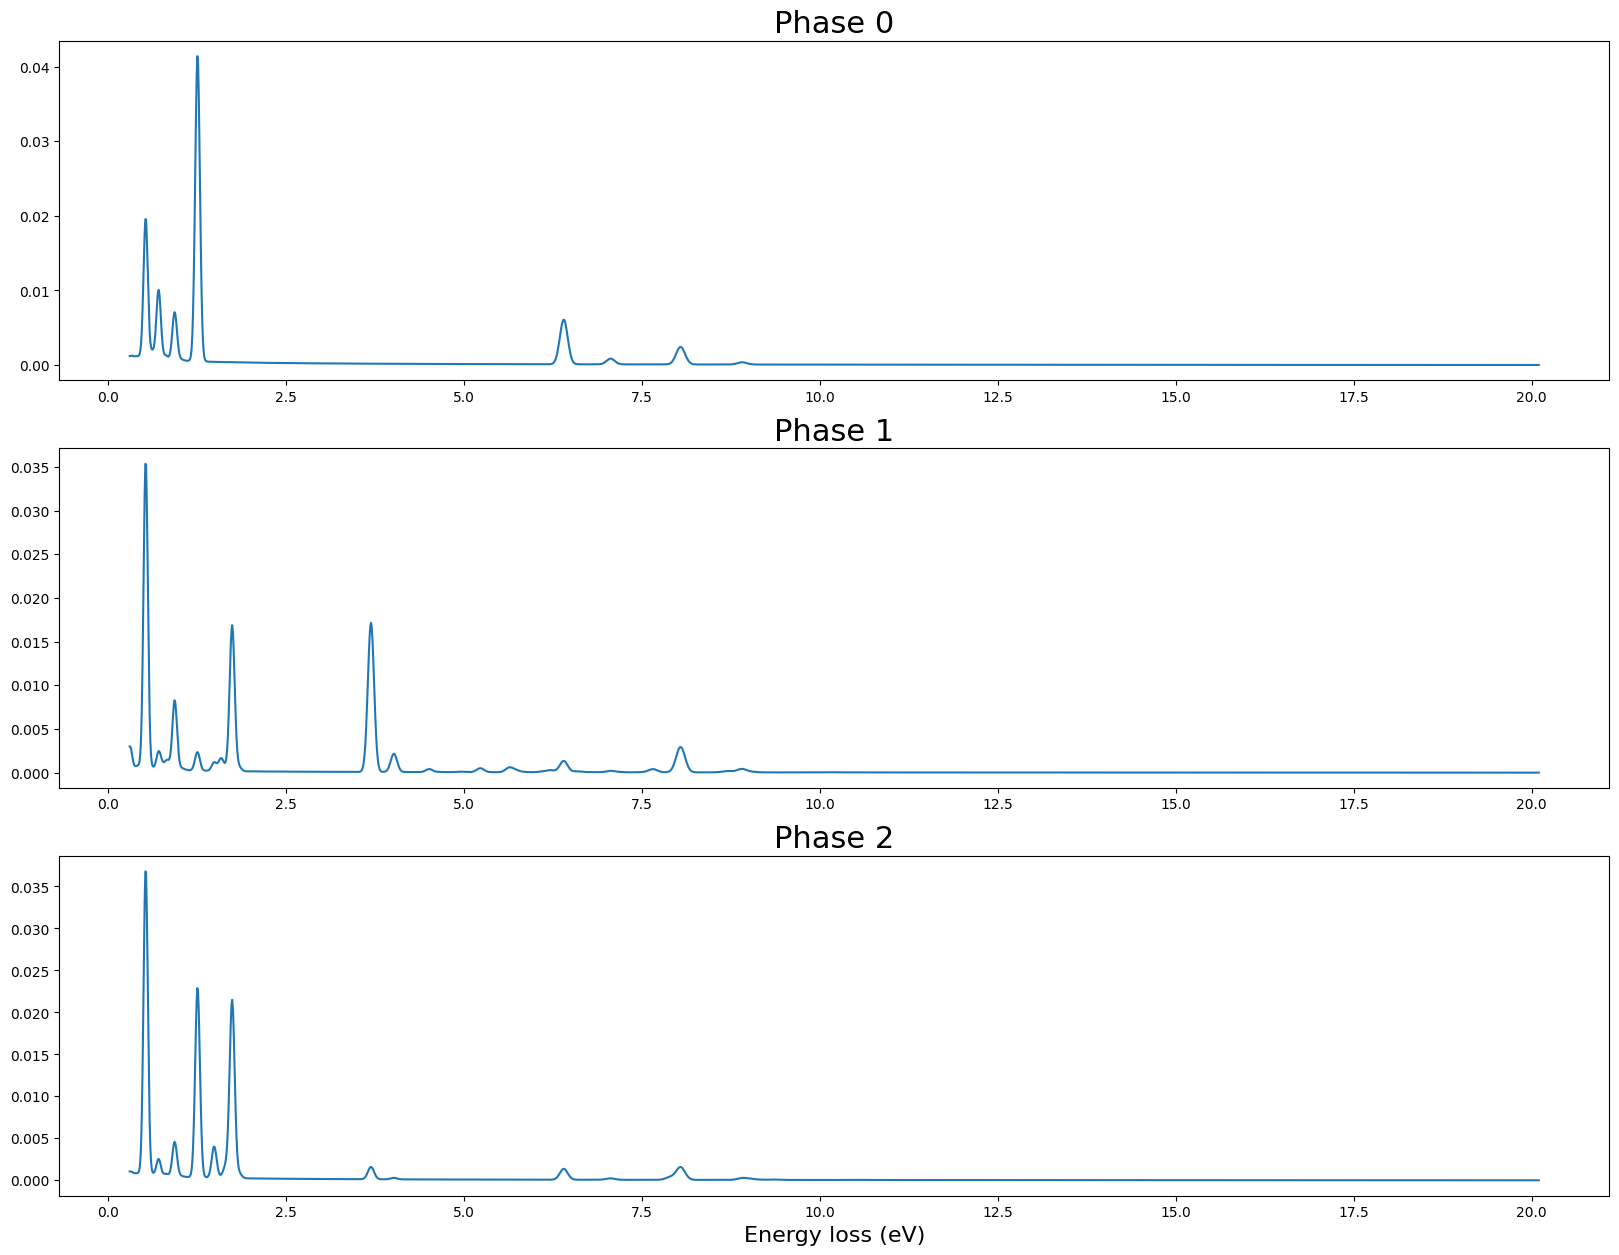

In [6]:
fig,axs = plt.subplots(3,1,figsize = (20,15))

# Build the energy scale
x = np.linspace(
    model_params["e_offset"],
    model_params["e_offset"]+model_params["e_scale"]*model_params["e_size"],
    num=model_params["e_size"])

for j in range(axs.shape[0]) :
    axs[j].plot(x,phases[j])
    axs[j].set_title("Phase {}".format(j),fontsize = 22)

axs[-1].set_xlabel("Energy loss (eV)",fontsize = 16)

### Generate the data

It will produce 1 spectrum images/sample in the target folder.

You can replace `seed_range` by the number of samples you want to generate.

In [7]:
generate_dataset( phases = phases,
                  weights = weights,
                  model_params = model_params,
                  misc_params = data_dict,
                  base_seed=data_dict["seed"],
                  sample_number=1,
                  elements = elements)

100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


The previous command will save the data in the `generated_datasets` folder defined in the `espm.conf.py` file.

You can also define the path where the data will be saved using the "base_path" argument